In [1]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from tensorwatch.saliency import saliency
from tensorwatch import image_utils, pytorch_utils
from torch.utils.data import DataLoader
from matplotlib.pyplot import imshow

from cifar import initialize_model

Files already downloaded and verified
8


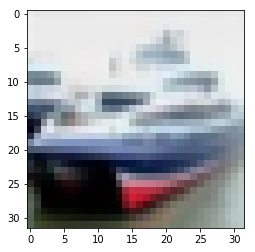

In [2]:
testset = datasets.CIFAR10(root="./data", train=False, download=True)
num_classes = 10

(image, class_index) = testset[1]
imshow(image)
label = torch.LongTensor([class_index])
print(class_index)

In [3]:
# add the torch.nn for loading model dict purposes
model = torch.nn.DataParallel(initialize_model("alexnet", 10))

checkpoint = torch.load("checkpoints/cifar10/alexnet/1/checkpoint.pth.tar")
model.load_state_dict(checkpoint["state_dict"])

# back to non data parallel AlexNet
model = list(model.children())[0]
print(model)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(5, 5))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Linear(in_features=256, out_features=10, bias=True)
)


In [4]:
image_tensor = transforms.ToTensor()(image)
norm_image_tensor = transforms.Normalize(
    (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))(image_tensor)

# add batch dimension
image_tensor.unsqueeze_(0)
norm_image_tensor.unsqueeze_(0)

if torch.cuda.is_available():
    image_tensor = image_tensor.cuda()
    norm_image_tensor = norm_image_tensor.cuda()
    label = label.cuda()

output = model(norm_image_tensor)
print(output.shape)
output.topk(k=1)

torch.Size([1, 10])


torch.return_types.topk(
values=tensor([[10.8530]], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([[8]], device='cuda:0'))

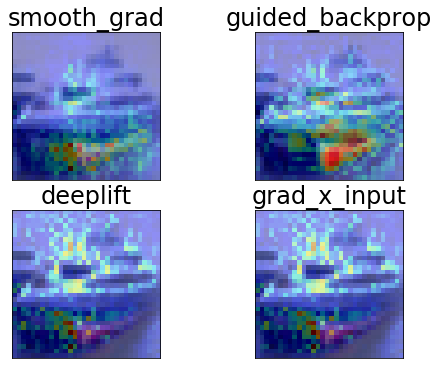

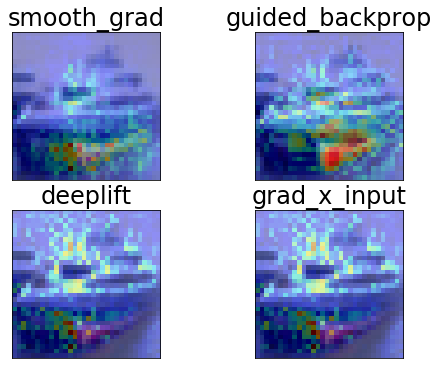

In [5]:
results = saliency.get_image_saliency_results(
    model, image, norm_image_tensor, label,
    methods=['smooth_grad', 'guided_backprop', 'deeplift', 'grad_x_input'])
saliency.get_image_saliency_plot(results)